# CNN-Based Denoising Autoencoder

__Notebook Author__: Hamed Qazanfari

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/hamedmit/VisionLab/blob/main/CNN-Based_Denoising_Autoencoder.ipynb)
[![Open In kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/hamedmit/VisionLab/blob/main/CNN-Based_Denoising_Autoencoder.ipynb)

---

## Notebook Objectives

This notebook implements a CNN-based autoencoder specifically designed for image denoising. The convolutional layers help retain spatial features, improving denoising performance or predict missing parts of an image. For this purpose, we use CIFAR-10, a more general dataset, to train a model that predicts the masked parts of the image.

1- Adding Mask noise to input images

2- Training the model to reconstruct clean images

3- Evaluating performance and comparing noisy vs. denoised images


In [ ]:
# @title setup and imports

import numpy as np
from matplotlib import pyplot as plt
from tqdm import trange

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

from torchvision import transforms, models
from torchvision.datasets.mnist import MNIST
from torchvision.datasets.cifar import CIFAR10

torch.manual_seed(0)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [12]:
# @title plotting functions

def plot_history(history):
    if 'train_acc' in history:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        ax1.plot(history['train_loss'], label='train')
        ax1.plot(history['test_loss'], label='test')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax2.plot(history['train_acc'], label='train')
        ax2.plot(history['test_acc'], label='test')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
    else:
        plt.plot(history['train_loss'], label='train')
        plt.plot(history['test_loss'], label='test')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
    plt.show()


def visualize(embedded, labels, title=''):
    fig, ax = plt.subplots(figsize=(12,8))

    # get discrete colormap
    cmap = plt.get_cmap('jet', 10) # virdis

    # plot scatter points
    scatter = ax.scatter(embedded[:, 0], embedded[:, 1], c=labels, cmap=cmap)

    # add colorbar
    cbar = plt.colorbar(scatter)

    # set ticks locations
    cbar.set_ticks((np.arange(10) + 0.5) * (10 - 1) / 10)

    # set tick labels
    cbar.set_ticklabels([str(i) for i in range(10)])

    plt.title(title)
    plt.show()


def plot_autoencoder(model, dataloader, method='PCA', denoising=False):
    with torch.no_grad():
        encoded_data, labels = [], []
        for imgs, lbls in dataloader:
            encoded = model.encoder(imgs.to(device))
            if denoising:
                encoded = encoded.view(encoded.size(0), -1)
            encoded_data.append(encoded.cpu().numpy())
            labels.append(lbls.cpu().numpy())

    # Concatenate the encoded representations and labels
    encoded_data = np.concatenate(encoded_data, axis=0)
    labels = np.concatenate(labels, axis=0)

    if encoded_data.shape[1] == 2:
        embedded = encoded_data
        title = 'Latent Space'
    elif method == 'PCA':
        embedded = PCA(n_components=2).fit_transform(encoded_data)
        title = 'Reduction of the Latent Space using PCA'
    else:
        embedded = TSNE(n_components=2, learning_rate='auto', init='random',
                        perplexity=3).fit_transform(encoded_data)
        title = 'Reduction of the Latent Space using t-SNE'

    visualize(embedded, labels, title)



def plot_reconstruction(model, dataset, denoising=False, mask=False):
    # Choose 10 random samples
    random_indices = np.random.choice(len(dataset), size=10, replace=False)

    # Get images and labels for the chosen samples
    images = [dataset[i][0] for i in random_indices]
    labels = [dataset[i][1] for i in random_indices]

    is_grayscale = images[0].shape[0]==1
    cmap = 'gray' if is_grayscale else None

    if denoising:
        noisy_images = [add_noise(image, mask=mask) for image in images]

    # Reconstruct the images using the autoencoder
    with torch.no_grad():
        if denoising:
            reconstructed_images = [model(noisy_image.unsqueeze(0).to(device)).squeeze().cpu() for noisy_image in noisy_images]
        else:
            reconstructed_images = [model(image.unsqueeze(0).to(device)).squeeze().cpu() for image in images]

    if denoising:
        # Display the original and reconstructed images
        fig, axes = plt.subplots(3, 10, figsize=(15, 5))

        # First row: Original images
        for i, image in enumerate(images):
            if is_grayscale:
                axes[0, i].imshow(image.squeeze().numpy(), cmap=cmap)
            else:
                axes[0, i].imshow(image.permute(1,2,0).numpy(), cmap=cmap)
            axes[0, i].set_title(f"Original {classes[labels[i]]}")
            axes[0, i].axis('off')

        # Second row: Noisy images
        for i, image in enumerate(noisy_images):
            if is_grayscale:
                axes[1, i].imshow(image.squeeze().numpy(), cmap=cmap)
            else:

                axes[1, i].imshow(image.permute(1,2,0).numpy(), cmap=cmap)
            axes[1, i].set_title(f"Noisy {classes[labels[i]]}")
            axes[1, i].axis('off')

        # Third row: Reconstructed images
        for i, image in enumerate(reconstructed_images):
            if is_grayscale:
                axes[2, i].imshow(image.squeeze().numpy().reshape(28, 28), cmap=cmap)
            else:
                axes[2, i].imshow(image.permute(1,2,0).numpy(), cmap=cmap)
            axes[2, i].set_title(f"Reconstructed")
            axes[2, i].axis('off')

    else:
        # Display the original and reconstructed images
        fig, axes = plt.subplots(2, 10, figsize=(15, 3))

        # First row: Original images
        for i, image in enumerate(images):
            if is_grayscale:
                axes[0, i].imshow(image.squeeze().numpy(), cmap=cmap)
            else:
                axes[0, i].imshow(image.permute(1,2,0).numpy(), cmap=cmap)
            axes[0, i].set_title(f"Label: {classes[labels[i]]}")
            axes[0, i].axis('off')

        # Second row: Reconstructed images
        for i, image in enumerate(reconstructed_images):
            if is_grayscale:
                axes[1, i].imshow(image.detach().numpy().reshape(28, 28), cmap=cmap)
            else:
                axes[1, i].imshow(image.detach().numpy(), cmap=cmap)
            axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

In [3]:
# @title AutoEncoder helper functions
def mask_image(x, square_size=5, number_of_squares=3):
    masked = x.clone()
    for _ in range(number_of_squares):
        start_i = torch.randint(0, x.shape[-2]-square_size, (1, ))
        start_j = torch.randint(0, x.shape[-1]-square_size, (1, ))
        masked[..., start_i:start_i+square_size, start_j:start_j+square_size]=0
    return masked

def add_noise(x, mask= False):
    if mask:
        return mask_image(x)

    select_mode = np.random.uniform()

    if select_mode <= 1/6: # gaussian noise
        noisy = x + torch.randn_like(x) * 0.5

    elif select_mode <= 2/6: # salt and pepper noise
        noise = torch.rand_like(x)
        noisy = x.clone()
        noisy[noise < 0.1] = 0
        noisy[noise > 0.9] = 1

    elif select_mode <= 3/6: # speckle noise
        noisy = x + x*torch.randn_like(x)

    elif select_mode <= 4/6: # poisson
        noisy = torch.poisson(x * 2)/2

    elif select_mode <= 5/6: # square masking
        noisy = mask_image(x, square_size=4, number_of_squares=4)

    else: # bluring
        noisy = transforms.GaussianBlur(5, sigma=(2,2))(x)

    noisy[noisy < 0] = 0
    noisy[noisy > 1] = 1
    return noisy

def autoencoder_train_step(model, dataloader, loss_fn, optimizer, denoising, mask, device):
    model.train()
    train_loss = 0.
    for images, _ in dataloader:
        images = images.to(device)
        if denoising: # Add noise to the images
            noisy_images = add_noise(images, mask= mask)
            recons = model(noisy_images)
        else:
            recons = model(images)
        loss = loss_fn(recons, images)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.item()
    train_loss /= len(dataloader)
    return train_loss


def autoencoder_test_step(model, dataloader, loss_fn, denoising, mask, device):
    model.eval()
    test_loss = 0.
    with torch.inference_mode():
        for images, _ in dataloader:
            images = images.to(device)
            if denoising: # Add noise to the images
                noisy_images = add_noise(images, mask=mask)
                recons = model(noisy_images)
            else:
                recons = model(images)
            loss = loss_fn(recons, images)
            test_loss += loss.item()
        test_loss /= len(dataloader)
    return test_loss


def train_autoencoder(model, train_dataloader, test_dataloader, n_epochs, denoising=False, mask=False, device=device):
    history = {'train_loss': [], 'test_loss': []}
    optimizer = Adam(model.parameters())
    loss_fn = nn.MSELoss()
    for _ in (pbar := trange(n_epochs)):
        train_loss = autoencoder_train_step(model, train_dataloader, loss_fn, optimizer, denoising, mask, device)
        history['train_loss'].append(train_loss)
        test_loss = autoencoder_test_step(model, test_dataloader, loss_fn, denoising, mask, device)
        history['test_loss'].append(test_loss)
        pbar.set_description(f'Training Loss {train_loss:.3f} | Test Loss {test_loss:.3f} ')
    return history


In [4]:
# @title CIFAR10 dataset
batch_size = 256

trainset = CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In Denoising AutoEncoders, the latent feature dimensions do not need to be smaller because the input and output are different. This prevents the model from simply learning the identity function without capturing meaningful features. As our data has become more complex, we require a more sophisticated model.

In [5]:
class DenoisingAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()

        # The Encoder Network
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=2, padding=1),  # (32x32x3) -> (16x16x64)
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),  # (16x16x64) -> (8x8x128)
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1),  # (8x8x128) -> (4x4x256)
            nn.ReLU(inplace=True)
        )

        # The Decoder Network
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1),  # (4x4x256) -> (8x8x128)
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1),  # (8x8x128) -> (16x16x64)
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=3, stride=2, padding=1, output_padding=1),  # (16x16x64) -> (32x32x3)
            nn.Sigmoid()
        )

    def forward(self, x):
        out = self.decoder(self.encoder(x))
        return out

We then train our Denoising AutoEncoder using masked data. Specifically, random squares of each input image are set to zero, and we expect the model to predict the content behind these masks in the output.

Training Loss 0.002 | Test Loss 0.002 : 100%|██████████| 30/30 [47:14<00:00, 94.48s/it]


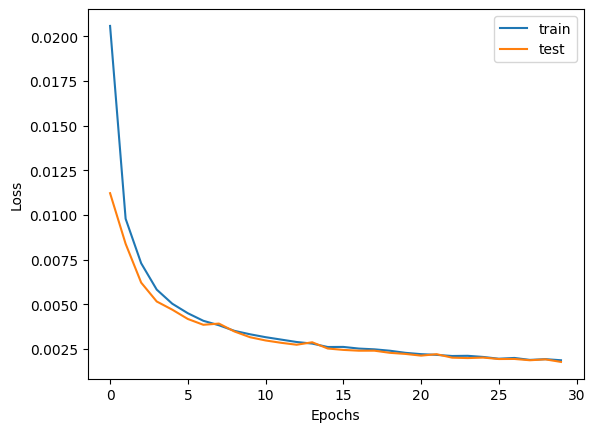

In [6]:
dae = DenoisingAutoEncoder().to(device)

res = train_autoencoder(dae, trainloader, testloader, n_epochs=30, denoising=True, mask=True)
plot_history(res)

At this stage, we test the trained model on noisy images and compare the results to evaluate how well the autoencoder removes noise.

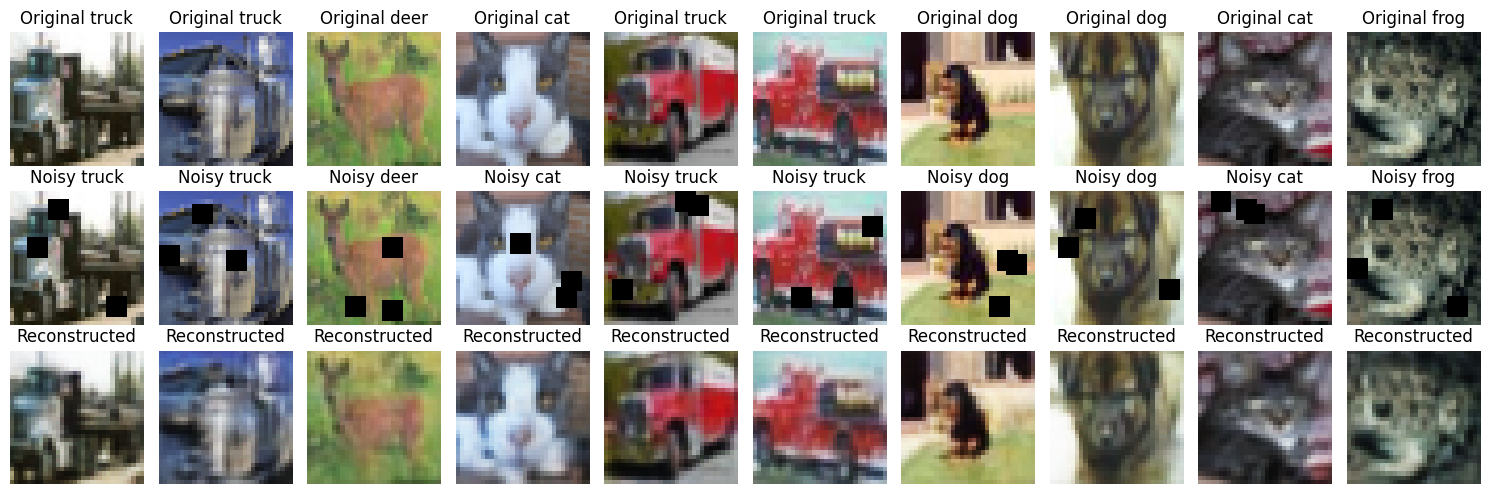

In [7]:
plot_reconstruction(dae, testset, denoising=True, mask=True)

Here we test the model with a real Cat image!

In [15]:
from PIL import Image
import torchvision.transforms as transforms
import torch

! gdown https://github.com/hamedmit/VisionLab/blob/main/my.jpg?raw=true -O my.jpg
# خواندن تصویر
image = Image.open("my.jpg")  # جایگزین با مسیر تصویر 

# تبدیل تصویر به فرمت مناسب برای مدل (تغییر سایز، تبدیل به Tensor، نرمال‌سازی)
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # تغییر سایز به 32x32
    transforms.ToTensor(),  # تبدیل به Tensor با مقدار بین [0,1]
])

input_image = transform(image).unsqueeze(0)  # اضافه کردن بُعد batch (1, 3, 32, 32)
noisy_image = mask_image(input_image)

dae.eval()  # تغییر وضعیت مدل به evaluation mode
with torch.no_grad():  # حذف محاسبه گرادیان برای سرعت بیشتر
    denoised_image = dae(noisy_image.to(device))  # عبور تصویر نویزی از مدل


Downloading...
From: https://github.com/hamedmit/VisionLab/blob/main/my.jpg?raw=true
To: c:\Users\DelbarJan-Hamed\Downloads\Programs\2025\my.jpg

  0%|          | 0.00/78.4k [00:00<?, ?B/s]
100%|██████████| 78.4k/78.4k [00:00<00:00, 177kB/s]
100%|██████████| 78.4k/78.4k [00:00<00:00, 176kB/s]


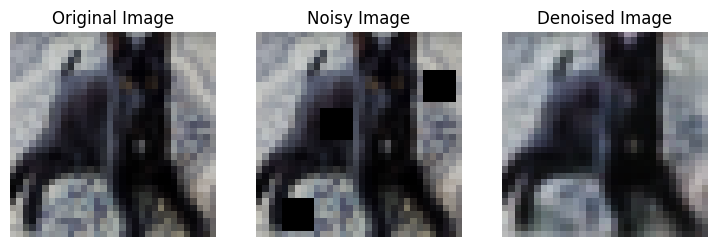

In [16]:
import matplotlib.pyplot as plt

# تبدیل Tensor به تصویر
def show_tensor_image(tensor, title="Image"):
    img = tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()  # تغییر ابعاد برای نمایش
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")

# نمایش تصویر ورودی، نویزی، و خروجی
plt.figure(figsize=(9, 3))
plt.subplot(1, 3, 1)
show_tensor_image(input_image, title="Original Image")

plt.subplot(1, 3, 2)
show_tensor_image(noisy_image, title="Noisy Image")

plt.subplot(1, 3, 3)
show_tensor_image(denoised_image, title="Denoised Image")

plt.show()


## Conclusion

Results show that using a CNN-based architecture for denoising performs significantly better than a fully connected autoencoder, as it preserves local image features. This approach is particularly useful in real-world applications such as medical imaging and digital noise reduction.